In [26]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Adjust the number of filters
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32  # Reduce the initial number of channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
# cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)

model_weights_path = "/kaggle/input/deeplearningproject/data_analysis/data_analysis/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

# Set the model to evaluation mode
cnn_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1

In [34]:
# Define paths to image folders
folder_paths = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/New_York',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/New_Orleans',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/London'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
results = {
    "London": {
        "2019": {"05-10-2019": [], "05-11-2019": [], "05-12-2019": [], "05-13-2019": [],
                 "05-14-2019": [], "05-15-2019": [], "05-16-2019": [], "05-17-2019": []},
        "2020": {"05-10-2020": [], "05-11-2020": [], "05-12-2020": [], "05-13-2020": [],
                 "05-14-2020": [], "05-15-2020": [], "05-16-2020": [], "05-17-2020": []},
        "2022": {"05-10-2022": [], "05-11-2022": [], "05-12-2022": [], "05-13-2022": [],
                 "05-14-2022": [], "05-15-2022": [], "05-16-2022": [], "05-17-2022": []}
    },
    "New York": {
        "2019": {"06-23-2019": [], "06-24-2019": [], "06-25-2019": [], "06-26-2019": [],
                 "06-27-2019": [], "06-28-2019": [], "06-29-2019": [], "06-30-2019": []},
        "2020": {"06-23-2020": [], "06-24-2020": [], "06-25-2020": [], "06-26-2020": [],
                 "06-27-2020": [], "06-28-2020": [], "06-29-2020": [], "06-30-2020": []},
        "2022": {"06-23-2022": [], "06-24-2022": [], "06-25-2022": [], "06-26-2022": [],
                 "06-27-2022": [], "06-28-2022": [], "06-29-2022": [], "06-30-2022": []}
    },
    "New Orleans": {
        "2019": {"05-20-2019": [], "05-21-2019": [], "05-22-2019": [], "05-23-2019": [],
                 "05-24-2019": [], "05-25-2019": [], "05-26-2019": [], "05-27-2019": []},
        "2020": {"05-20-2020": [], "05-21-2020": [], "05-22-2020": [], "05-23-2020": [],
                 "05-24-2020": [], "05-25-2020": [], "05-26-2020": [], "05-27-2020": []},
        "2022": {"05-20-2022": [], "05-21-2022": [], "05-22-2022": [], "05-23-2022": [],
                 "05-24-2022": [], "05-25-2022": [], "05-26-2022": [], "05-27-2022": []}
    }
}

def predict_image(image, model):
    model.eval()
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        count = model(image)
    return count.item()


for city, path in folder_paths.items():
    
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            year = date.split('-')[-1]
            
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert('RGB')
            count = predict_image(image, cnn_model)
            
            if year in results[city]:
                results[city][year][date].append(count)

In [40]:
averages = {}

for city, years in results.items():
    averages[city] = {}
    for year, days in years.items():
        averages[city][year] = {}
        for day, counts in days.items():
            avg_count = sum(counts) / len(counts) if counts else 0
            averages[city][year][day] = avg_count

In [41]:
averages

{'London': {'2019': {'05-10-2019': 3.3836138248443604,
   '05-11-2019': 3.7341843950442777,
   '05-12-2019': 5.110283502097269,
   '05-13-2019': 3.1481325091986823,
   '05-14-2019': 3.6771789312362673,
   '05-15-2019': 0,
   '05-16-2019': 0,
   '05-17-2019': 0},
  '2020': {'05-10-2020': 1.0029468536376953,
   '05-11-2020': 3.3645296121296817,
   '05-12-2020': 3.038553610995964,
   '05-13-2020': 3.6149408148752675,
   '05-14-2020': 2.9598834969333767,
   '05-15-2020': 3.1188936278871866,
   '05-16-2020': 5.1037715560403365,
   '05-17-2020': 4.677190588933174},
  '2022': {'05-10-2022': 2.16746187210083,
   '05-11-2022': 3.7037730790950634,
   '05-12-2022': 4.166089414369942,
   '05-13-2022': 4.4970636991696935,
   '05-14-2022': 4.031636025615319,
   '05-15-2022': 3.8359665907919407,
   '05-16-2022': 3.9231626653485723,
   '05-17-2022': 3.900773491626395}},
 'New York': {'2019': {'06-23-2019': 12.248796463012695,
   '06-24-2019': 7.304551315307617,
   '06-25-2019': 8.550206969766055,
   '

In [44]:
def flatten_averages(averages):
    flattened = []
    for city, years in averages.items():
        for year, date in years.items():
            for date, avg_count in date.items():
                flattened.append((city, date, avg_count))
    return flattened

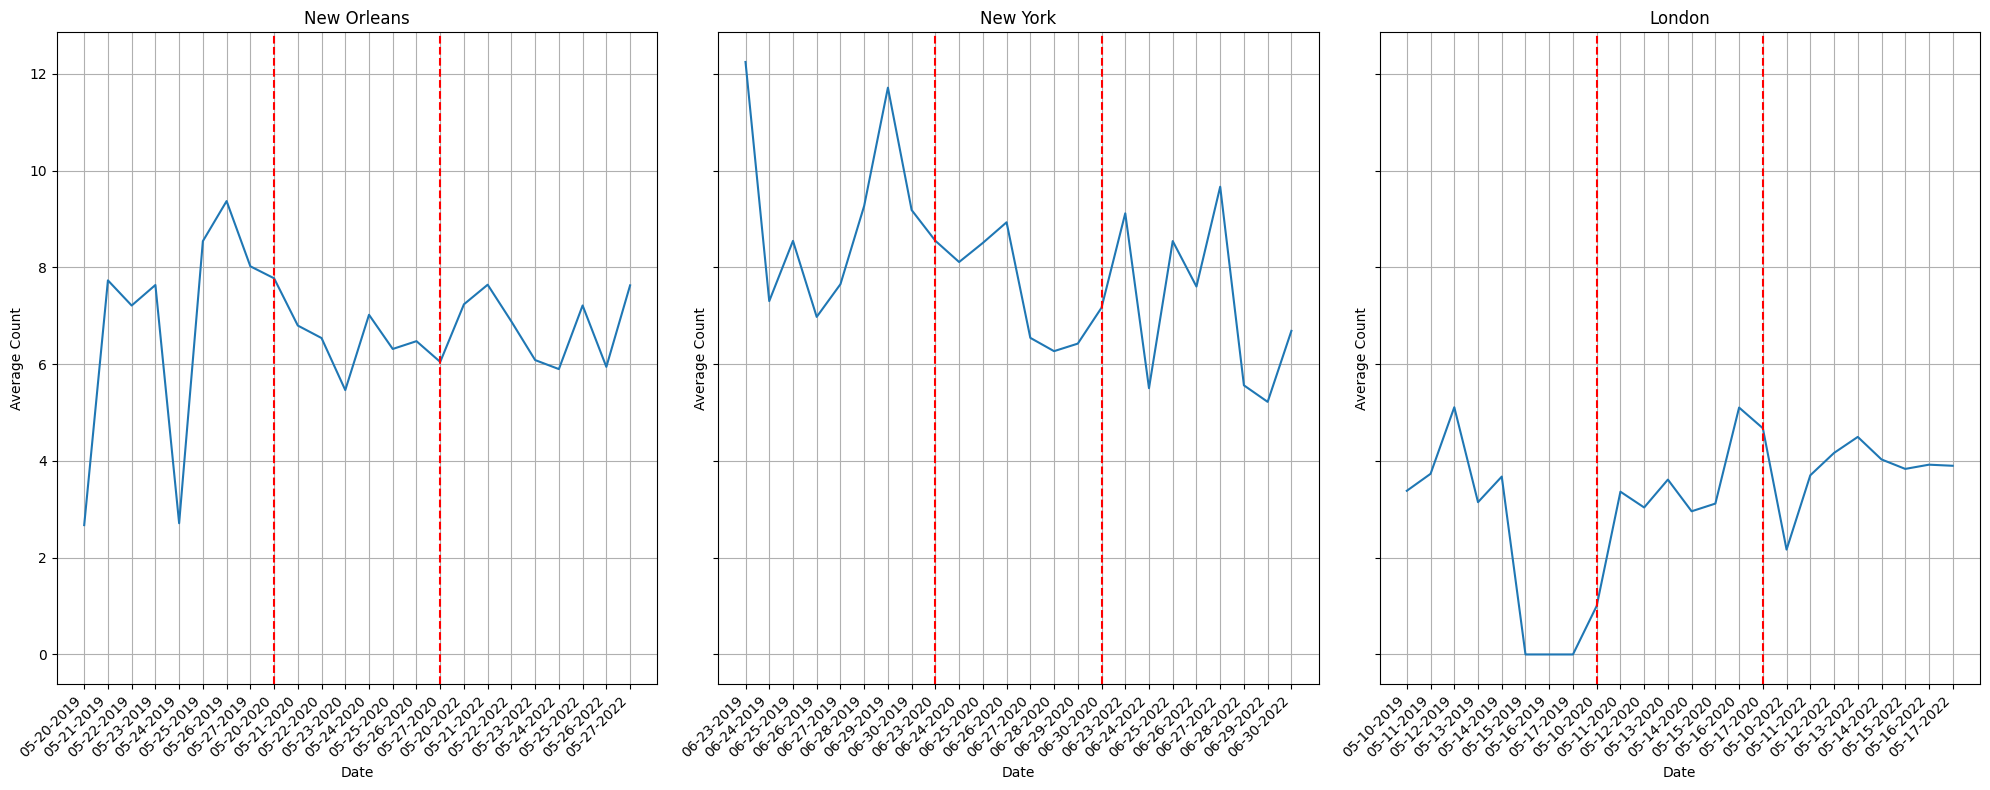

In [62]:
data = flatten_averages(averages)

fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=False, sharey=True)

cities = list(set(item[0] for item in data_sorted))
first_dates_2020 = {"London": "05-10-2020",
                    "New York": "06-23-2020",
                    "New Orleans": "05-20-2020"}
last_dates_2020 = {"London": "05-17-2020",
                   "New York": "06-30-2020",
                   "New Orleans": "05-27-2020"}

for i, city in enumerate(cities):
    city_data = [(date, avg_count) for c, date, avg_count in data if c == city]
    
    if city_data:
        dates, counts = zip(*city_data)
        axs[i].plot(dates, counts, label=city)
        axs[i].set_title(f'{city}')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Average Count')
        axs[i].grid(True)
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axs[i].axvline(x=first_dates_2020[city], color="red", linestyle ="--")
        axs[i].axvline(x=last_dates_2020[city], color="red", linestyle ="--")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()